# Improving the Penguin Classifier - fastai transforms (1)


Testing different transform parameters: 
* resize_method (pad, crop, squish)
* padding_mode (zeros, border, reflection)
* size (square or rectangle)

For details on these see the fastai docs https://docs.fast.ai/vision.transform.html

In [1]:
from fastai.vision import *
from fastai.utils.mem import *
from fastai.utils import *
import torch
import gc

## Set up data

In [2]:
path = Path('data/penguins')

In [3]:
classes = ['adelie', 'african', 'chinstrap', 'emperor', 'erect_crested', 'fiordland', 'galapagos', 'gentoo', 'humboldt', 
           'king', 'little', 'macaroni', 'magellanic', 'rockhopper', 'royal', 'snares', 'yellow_eyed']

## Function to try out all of the different combinations

In [4]:
# set up parameter lists
resize_methods = [ResizeMethod.PAD, ResizeMethod.CROP, ResizeMethod.SQUISH]
padding_methods = ['zeros', 'border', 'reflection']
sizes = [244, (300,200)]

In [5]:
def create_data_bunch(r, p, s):
    # setting this will make sure the same validation set is created each time
    np.random.seed(42)
    # create data bunch
    data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), 
            resize_method=r, padding_mode=p, size=s, 
            bs=16, num_workers=4).normalize(imagenet_stats)
    return data

In [6]:
# create an array of data bunches
i = 0
data_bunches = {}
for r in resize_methods:
    for p in padding_methods:
        for s in sizes:
            print('test', i, r, p, s)
            data_bunches['test-' + str(i)] = create_data_bunch(r,p,s)   
            i=i+1
        

test 0 ResizeMethod.PAD zeros 244
test 1 ResizeMethod.PAD zeros (300, 200)
test 2 ResizeMethod.PAD border 244
test 3 ResizeMethod.PAD border (300, 200)
test 4 ResizeMethod.PAD reflection 244
test 5 ResizeMethod.PAD reflection (300, 200)


D:\Programs\Anaconda\envs\fastai2019\lib\site-packages\fastai\basic_data.py:259: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 324
  warn(warn_msg)


You can deactivate this warning by passing `no_check=True`.
test 6 ResizeMethod.CROP zeros 244
test 7 ResizeMethod.CROP zeros (300, 200)
test 8 ResizeMethod.CROP border 244
test 9 ResizeMethod.CROP border (300, 200)
test 10 ResizeMethod.CROP reflection 244
test 11 ResizeMethod.CROP reflection (300, 200)
test 12 ResizeMethod.SQUISH zeros 244
test 13 ResizeMethod.SQUISH zeros (300, 200)
test 14 ResizeMethod.SQUISH border 244
test 15 ResizeMethod.SQUISH border (300, 200)
test 16 ResizeMethod.SQUISH reflection 244
test 17 ResizeMethod.SQUISH reflection (300, 200)


In [13]:
# clean memory
def clean_memory():
    collect_result = gc.collect()
    torch.cuda.empty_cache()
    mem_use = gpu_mem_get()
    print('memory in use' + str(mem_use))
    print('')
   

In [8]:
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

In [9]:
@gpu_mem_restore
def run_tests(data_bunch_dict, cycles):
    for key,val in data_bunch_dict.items():
        print(key)
        data = val
        learn = cnn_learner(data, models.resnet34, metrics=error_rate)
        try:
            learn.fit_one_cycle(cycles)
            learn.save(key)
        except Exception as e:
            print('exception in ', key, e)
        del(data)
        del(learn)
        clean_memory()

In [10]:
gpu_mem_get()

GPUMemory(total=2048, free=1979, used=68)

In [11]:
clean_memory()

clean_memory
gc.collect() 0
memory in useGPUMemory(total=2048, free=1979, used=68)


In [12]:
# combinations in test-4 and test-5 fail so lets remove them 
if 'test-4' in data_bunches:
    del data_bunches['test-4']
if 'test-5' in data_bunches:
    del data_bunches['test-5']
len(data_bunches)

16

In [14]:
#do the tests
run_tests(data_bunches,4)

test-0


epoch,train_loss,valid_loss,error_rate,time
0,1.972148,1.094785,0.345324,01:05
1,1.226800,0.769689,0.237410,00:51
2,0.916397,0.668279,0.217626,00:51
3,0.718850,0.648817,0.185252,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-1


epoch,train_loss,valid_loss,error_rate,time
0,2.025141,1.296055,0.419065,00:57
1,1.257313,0.956518,0.303957,00:56
2,0.989595,0.800951,0.262590,00:54
3,0.811785,0.761055,0.250000,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-2


epoch,train_loss,valid_loss,error_rate,time
0,1.933962,1.065788,0.357914,00:51
1,1.182230,0.805391,0.269784,00:51
2,0.847574,0.690324,0.233813,00:51
3,0.758472,0.648619,0.219424,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-3


epoch,train_loss,valid_loss,error_rate,time
0,1.964156,1.167503,0.386691,00:54
1,1.250406,0.823010,0.266187,00:53
2,0.919841,0.716990,0.241007,00:54
3,0.741230,0.705090,0.233813,00:53


memory in useGPUMemory(total=2048, free=1541, used=506)

test-6


epoch,train_loss,valid_loss,error_rate,time
0,1.956347,1.068367,0.318345,00:52
1,1.214816,0.751492,0.244604,00:51
2,0.968350,0.664658,0.215827,00:51
3,0.810891,0.653460,0.210432,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-7


epoch,train_loss,valid_loss,error_rate,time
0,1.913306,1.053573,0.332734,00:55
1,1.248550,0.830362,0.257194,00:56
2,0.953694,0.711846,0.228417,00:54
3,0.813795,0.711590,0.239209,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-8


epoch,train_loss,valid_loss,error_rate,time
0,1.877674,0.981377,0.294964,00:53
1,1.223554,0.739339,0.242806,00:53
2,0.936406,0.635706,0.194245,00:51
3,0.780234,0.613530,0.188849,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-9


epoch,train_loss,valid_loss,error_rate,time
0,1.885007,1.021450,0.307554,00:56
1,1.264052,0.796967,0.233813,00:54
2,0.948114,0.678926,0.226619,00:54
3,0.901321,0.652365,0.214029,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-10


epoch,train_loss,valid_loss,error_rate,time
0,1.910940,1.045578,0.323741,00:52
1,1.263621,0.830783,0.278777,00:51
2,0.963742,0.717126,0.203237,00:51
3,0.800722,0.682337,0.206835,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-11


epoch,train_loss,valid_loss,error_rate,time
0,1.980471,1.019015,0.325540,00:54
1,1.277327,0.789978,0.258993,00:54
2,0.962115,0.702724,0.224820,00:54
3,0.818649,0.676778,0.208633,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-12


epoch,train_loss,valid_loss,error_rate,time
0,1.850989,0.983318,0.314748,00:51
1,1.127100,0.782756,0.246403,01:07
2,0.844618,0.667033,0.219424,00:51
3,0.672054,0.647640,0.210432,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-13


epoch,train_loss,valid_loss,error_rate,time
0,1.882261,1.072433,0.347122,00:54
1,1.209584,0.798045,0.258993,00:54
2,0.896356,0.664155,0.214029,00:54
3,0.663465,0.655482,0.215827,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-14


epoch,train_loss,valid_loss,error_rate,time
0,1.724818,0.984457,0.325540,00:51
1,1.104860,0.739304,0.244604,00:51
2,0.810929,0.657898,0.223022,00:51
3,0.660032,0.638908,0.210432,00:51


memory in useGPUMemory(total=2048, free=1541, used=506)

test-15


epoch,train_loss,valid_loss,error_rate,time
0,1.867508,1.073950,0.341727,00:54
1,1.183210,0.784156,0.226619,00:56
2,0.858979,0.659910,0.201439,00:53
3,0.693532,0.650867,0.203237,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-16


epoch,train_loss,valid_loss,error_rate,time
0,1.822588,0.928433,0.271583,00:51
1,1.076417,0.737776,0.239209,00:51
2,0.879227,0.645651,0.205036,00:52
3,0.638045,0.615165,0.197842,00:54


memory in useGPUMemory(total=2048, free=1541, used=506)

test-17


epoch,train_loss,valid_loss,error_rate,time
0,1.819862,1.048530,0.341727,00:56
1,1.158541,0.808860,0.282374,00:56
2,0.848359,0.682837,0.205036,00:57
3,0.663065,0.671235,0.203237,01:00


memory in useGPUMemory(total=2048, free=1541, used=506)



### Results (resulting error rate after 4 cycles)

Result 1 - running with _tofp16()
Result 2 - runnnig with normal learner


|Test|Resize Method| Pad Method | Size | Result 1| Result 2|
|----|-------------|------------|------|---------|---------|
|test 0 |ResizeMethod.PAD |zeros| 244|0.223022|0.185252|
|test 1 |ResizeMethod.PAD |zeros |(300, 200)|0.253597|0.250000|
|test 2 |ResizeMethod.PAD |border |244|0.208633|0.219424|
|test 3 |ResizeMethod.PAD |border |(300, 200)| 0.215827|0.233813|
|test 4 |ResizeMethod.PAD |reflection |244|X|X|
|test 5 |ResizeMethod.PAD |reflection |(300, 200)|X|X|
|test 6 |ResizeMethod.CROP |zeros |244|0.206835|0.210432|
|test 7 |ResizeMethod.CROP |zeros |(300, 200)|0.205036|0.239209	|
|test 8 |ResizeMethod.CROP |border | 244|0.201439|0.188849|
|test 9 |ResizeMethod.CROP |border |(300, 200)|0.201439|0.214029|
|test 10 |ResizeMethod.CROP |reflection |244|0.205036|0.206835|
|test 11 |ResizeMethod.CROP |reflection |(300, 200)|0.206835|0.208633|
|test 12 |ResizeMethod.SQUISH |zeros |244|0.214029|0.210432|
|test 13 |ResizeMethod.SQUISH |zeros |(300, 200)|0.206835|0.215827|
|__test 14__ |ResizeMethod.SQUISH |border |244|__0.176259__|0.210432|
|test 15 |ResizeMethod.SQUISH |border |(300, 200)|0.208633|0.203237|
|__test 16__ |ResizeMethod.SQUISH |reflection |244|0.197842|__0.197842__|
|test 17 |ResizeMethod.SQUISH |reflection |(300, 200)|0.201439|0.203237|


Test 14 came out best, with the SQUISH method of resizing, square size and border padding

For test 14, now lets try with fp32

In [49]:
@gpu_mem_restore
def do_cycles(test, cycles):
    data = data_bunches[test]
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(cycles)
    learn.save(test +'-2')
    return learn

@gpu_mem_restore
def do_lr_find_2(learn):
    learn.unfreeze()
    learn.lr_find()

In [42]:
clean_memory()

clean_memory
gc.collect() 44533
memory in useGPUMemory(total=2048, free=1541, used=506)


In [46]:
learn = do_cycles('test-14', 4)

epoch,train_loss,valid_loss,error_rate,time
0,1.818802,0.954086,0.300360,00:54
1,1.085639,0.709609,0.224820,00:55
2,0.842083,0.665336,0.197842,00:51
3,0.639584,0.629933,0.208633,00:51


In [50]:
do_lr_find_2(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


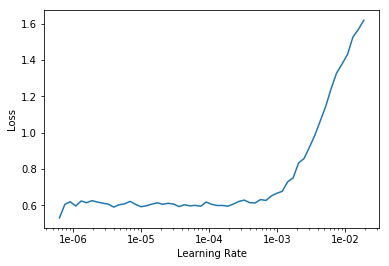

In [51]:
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.601972,0.565267,0.188849,01:08
1,0.537518,0.475903,0.136691,01:08
2,0.379271,0.457505,0.133094,01:07
3,0.328973,0.447495,0.131295,01:07


In [53]:
# save the learner
learn.save('test-14-lr')

clean_memory
gc.collect() 6483
memory in useGPUMemory(total=2048, free=991, used=1056)


Let's have a look at some of the images from data bunch 14

In [35]:
data = data_bunches['test-14']

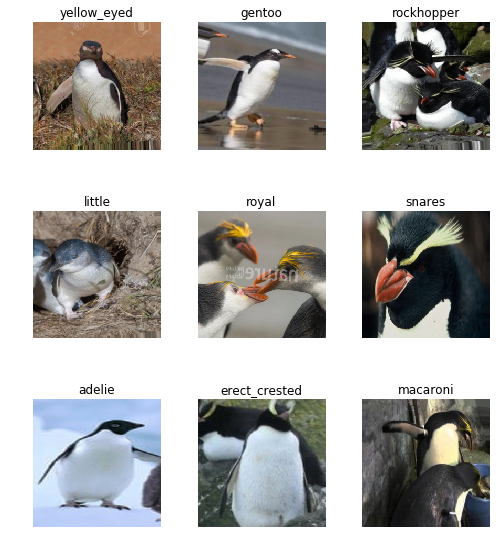

In [38]:
data.show_batch(rows=3, figsize=(7,8))

## Interpretation

Lets look at the results

In [64]:
learn = None
data = None
interp = None
clean_memory()

clean_memory
gc.collect() 40
memory in useGPUMemory(total=2048, free=1541, used=506)


In [56]:
# first test was fp16
data = data_bunches['test-14']
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
learn.load('test-14')
interp = ClassificationInterpretation.from_learner(learn)

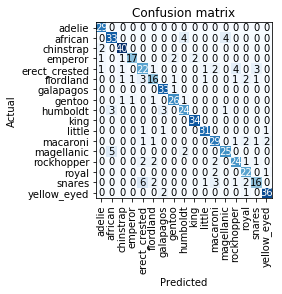

In [58]:
interp.plot_confusion_matrix()

In [59]:
interp.most_confused(min_val=2)

[('snares', 'erect_crested', 6),
 ('magellanic', 'african', 5),
 ('african', 'humboldt', 4),
 ('african', 'magellanic', 4),
 ('erect_crested', 'rockhopper', 4),
 ('erect_crested', 'snares', 3),
 ('fiordland', 'erect_crested', 3),
 ('humboldt', 'african', 3),
 ('humboldt', 'galapagos', 3),
 ('snares', 'macaroni', 3),
 ('chinstrap', 'adelie', 2),
 ('emperor', 'gentoo', 2),
 ('emperor', 'king', 2),
 ('erect_crested', 'macaroni', 2),
 ('fiordland', 'royal', 2),
 ('macaroni', 'royal', 2),
 ('macaroni', 'yellow_eyed', 2),
 ('magellanic', 'humboldt', 2),
 ('rockhopper', 'erect_crested', 2),
 ('rockhopper', 'fiordland', 2),
 ('rockhopper', 'macaroni', 2),
 ('royal', 'macaroni', 2),
 ('snares', 'fiordland', 2),
 ('snares', 'royal', 2),
 ('yellow_eyed', 'galapagos', 2)]

These are a bit odd:
 ('chinstrap', 'adelie', 2),
 ('emperor', 'gentoo', 2),
 ('emperor', 'king', 2),
 ('macaroni', 'yellow_eyed', 2),
 ('yellow_eyed', 'galapagos', 2)]

In [62]:
# second test was fp32
data = data_bunches['test-14']
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp32()
learn.load('test-14-32')
interp = ClassificationInterpretation.from_learner(learn)

In [63]:
interp.most_confused(min_val=2)

[('african', 'humboldt', 8),
 ('african', 'magellanic', 5),
 ('little', 'galapagos', 5),
 ('snares', 'erect_crested', 5),
 ('erect_crested', 'rockhopper', 4),
 ('macaroni', 'fiordland', 4),
 ('snares', 'macaroni', 4),
 ('emperor', 'king', 3),
 ('erect_crested', 'fiordland', 3),
 ('erect_crested', 'macaroni', 3),
 ('fiordland', 'erect_crested', 3),
 ('fiordland', 'snares', 3),
 ('macaroni', 'rockhopper', 3),
 ('macaroni', 'snares', 3),
 ('magellanic', 'african', 3),
 ('magellanic', 'humboldt', 3),
 ('snares', 'fiordland', 3),
 ('emperor', 'chinstrap', 2),
 ('fiordland', 'rockhopper', 2),
 ('fiordland', 'royal', 2),
 ('galapagos', 'magellanic', 2),
 ('gentoo', 'fiordland', 2),
 ('humboldt', 'galapagos', 2),
 ('macaroni', 'erect_crested', 2),
 ('royal', 'macaroni', 2),
 ('yellow_eyed', 'galapagos', 2)]

 ('little', 'galapagos', 5),
 ('emperor', 'king', 3),
 ('emperor', 'chinstrap', 2),
 ('yellow_eyed', 'galapagos', 2)

In [65]:
# after adjusting learning rate
data = data_bunches['test-14']
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.load('test-14-lr')
interp = ClassificationInterpretation.from_learner(learn)

In [66]:
interp.most_confused(min_val=2)

[('fiordland', 'snares', 6),
 ('macaroni', 'snares', 4),
 ('snares', 'macaroni', 4),
 ('african', 'humboldt', 3),
 ('african', 'magellanic', 3),
 ('erect_crested', 'macaroni', 3),
 ('little', 'galapagos', 3),
 ('erect_crested', 'fiordland', 2),
 ('erect_crested', 'rockhopper', 2),
 ('erect_crested', 'snares', 2),
 ('fiordland', 'erect_crested', 2),
 ('fiordland', 'magellanic', 2),
 ('fiordland', 'royal', 2),
 ('macaroni', 'erect_crested', 2),
 ('rockhopper', 'erect_crested', 2),
 ('snares', 'erect_crested', 2)]

ok that's a bit more like it. Still surprised by this though:  ('little', 'galapagos', 3)